# Vanilla LSTM for Time Series Forecasting
This project demonstrates how to use a Vanilla LSTM (Long Short-Term Memory) model to predict future values of a time series dataset. We use the Daily Minimum Temperatures in Melbourne, Australia (1981–1990) dataset for the demonstration.

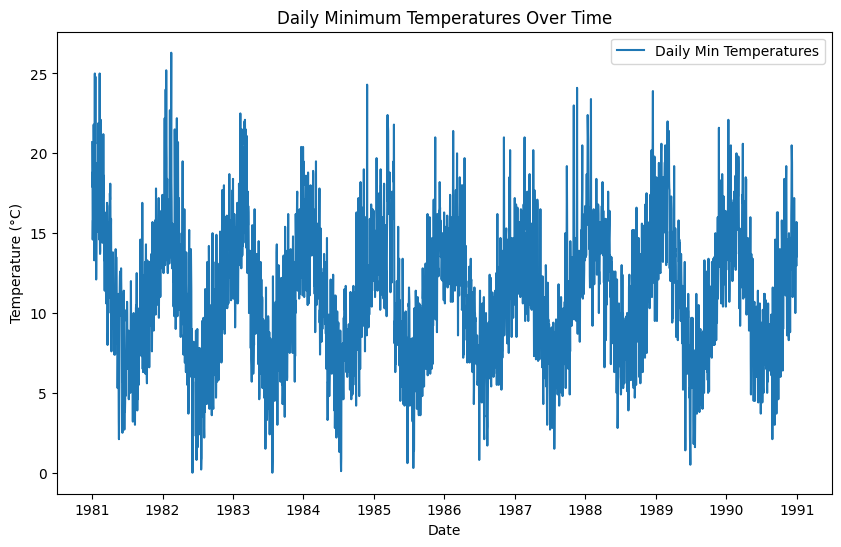

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(data['Temp'], label="Daily Min Temperatures")
plt.title("Daily Minimum Temperatures Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()
print(data.head())


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Temp']])
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)
SEQ_LENGTH = 30
x, y = create_sequences(data_scaled, SEQ_LENGTH)
import torch
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [ ]:
import torch.nn as nn

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(VanillaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
input_size = 1
hidden_size = 50
num_layers = 1
model = VanillaLSTM(input_size, hidden_size, num_layers)


# Train the Model
Split the data into training and test sets. Train the LSTM model using Mean Squared Error (MSE) loss and the Adam optimizer.

In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_size = int(len(x_tensor) * 0.8)
x_train, y_train = x_tensor[:train_size], y_tensor[:train_size]
x_test, y_test = x_tensor[train_size:], y_tensor[train_size:]
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 0.0851
Epoch [20/50], Loss: 0.0261
Epoch [30/50], Loss: 0.0198
Epoch [40/50], Loss: 0.0202
Epoch [50/50], Loss: 0.0190


# Evaluate the Model
Evaluate the trained model on the test set and visualize the predicted vs. actual values.

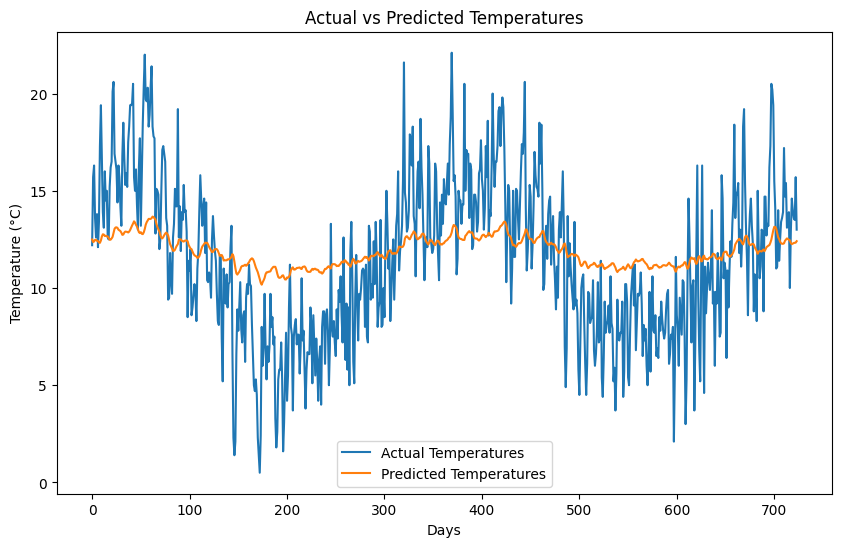

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(x_test).numpy()
    y_test_numpy = y_test.numpy()
predictions = scaler.inverse_transform(predictions)
y_test_numpy = scaler.inverse_transform(y_test_numpy)
plt.figure(figsize=(10, 6))
plt.plot(y_test_numpy, label="Actual Temperatures")
plt.plot(predictions, label="Predicted Temperatures")
plt.title("Actual vs Predicted Temperatures")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()
